# Notebook **One** - Identifying the position(s) of Brightest Cluster Galaxies (BCGs)

## Import statements and reading history/sample

In [1]:
%matplotlib ipympl

from ident_run_setup import cosmo, side_length, HISTORY_FILE_PATH, load_history, proj_name, update_history, InteractiveView

import matplotlib
from matplotlib import pyplot as plt
# from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
pd.set_option('display.max_columns', 500)

The framework I've designed for this process (i.e. these notebooks) is trying to keep a useful history of the process - it has recorded the images that we were able to download or generate, and which you'll be looking at in this notebook - and will also help you to more easily record the galaxies that you identify as being possible BCGs. 

**As this hasn't been tested much, it might be a good idea to keep your own backup copies of the coordinates you identify, by copying the 'history/bcg_ident_proj_save.json' file to some other place on your computer when you're done with each session of identifying BCGs - you could also change the name to add the date and time you made the copy** 

In [2]:
cur_history = load_history()

We read the total sample file into a Pandas dataframe:

In [3]:
# This reads the 'comma separated variable', or CSV/csv, file (which contains information about the sample of clusters
#  being investigated), from disk (on the hard-disk drive\HDD, or solid state disk\SSD) into memory (a much faster form of storage 
#  called Random Access Memory\RAM, where files being used by the operating system or currently running software live). We are using 
#  a Python module called 'Pandas' to read it in - think of it almost like a Python version of Excel
samp = pd.read_csv(cur_history['static_samp_file'])
# This method shows the top two lines of the loaded-in sample file
samp.head(2)

,name,cent_im_ra,cent_im_dec,redshift,r500,r500-,r500+,r2500,r2500-,r2500+,XCS_NAME,ang_prop_ratio
0,SDSSXCS-124,0.800578,-6.091818,0.247483,1181.028159,21.202221,23.202641,534.834740,7.579124,7.591855,XMMXCS J000312.1-060530.5,232.859967
1,SDSSXCS-2789,0.955540,2.068019,0.105285,1007.860978,17.194150,17.201505,438.706515,5.198301,5.213676,XMMXCS J000349.3+020404.8,115.802997


All cluster names:

In [4]:
print(list(samp['name'].values))

['SDSSXCS-124', 'SDSSXCS-2789', 'SDSSXCS-290', 'SDSSXCS-1018', 'SDSSXCS-134', 'SDSSXCS-119', 'SDSSXCS-209', 'SDSSXCS-15', 'SDSSXCS-71', 'SDSSXCS-5020', 'SDSSXCS-2346', 'SDSSXCS-586', 'SDSSXCS-11331', 'SDSSXCS-28849', 'SDSSXCS-31144', 'SDSSXCS-239', 'SDSSXCS-395', 'SDSSXCS-944', 'SDSSXCS-593', 'SDSSXCS-35404', 'SDSSXCS-7190', 'SDSSXCS-7783', 'SDSSXCS-5743', 'SDSSXCS-1131', 'SDSSXCS-29799', 'SDSSXCS-852', 'SDSSXCS-5830', 'SDSSXCS-5977', 'SDSSXCS-16227', 'SDSSXCS-2984', 'SDSSXCS-6955', 'SDSSXCS-64824', 'SDSSXCS-8366', 'SDSSXCS-120', 'SDSSXCS-572', 'SDSSXCS-226', 'SDSSXCS-22', 'SDSSXCS-103', 'SDSSXCS-212', 'SDSSXCS-19922', 'SDSSXCS-890', 'SDSSXCS-31', 'SDSSXCS-325', 'SDSSXCS-26424', 'SDSSXCS-5159', 'SDSSXCS-9803', 'SDSSXCS-1884', 'SDSSXCS-5', 'SDSSXCS-13', 'SDSSXCS-5225', 'SDSSXCS-21', 'SDSSXCS-23', 'SDSSXCS-617', 'SDSSXCS-6245', 'SDSSXCS-21847', 'SDSSXCS-22748', 'SDSSXCS-9', 'SDSSXCS-8060', 'SDSSXCS-15984', 'SDSSXCS-75', 'SDSSXCS-667', 'SDSSXCS-9258', 'SDSSXCS-1628', 'SDSSXCS-7405', 'SDSS

## A CAVEAT

For technical reasons that I won't explain here, the only to get this interactive plot process working in Jupyter Notebooks (in its current form at least) is to run the notebook for one cluster, then restart it and run it again for the next, and so on.

This stepping through of clusters will happen automatically - once the project history has an entry for BCG coordinates from your investigation, the next time the notebook is run it will move on to the next cluster without BCG coordinates. If you want to go back to a specific cluster and overwrite your first attempt, you can set the variable below to the cluster name (e.g. 'SDSSXCS-124', make sure the name is a string with the '' around it) - **before you run the notebook again, make sure to set `overwrite_cluster=None`, and note that None doesn't have any '' around it, as it is not a string**

In [5]:
# You can change this per the instructions above
overwrite_cluster = None

# Don't change this though
if overwrite_cluster is not None and overwrite_cluster not in samp['name'].values:
    raise ValueError("The overwriting cluster name you set does not correspond to a name in the sample, check "\
        "to make sure you typed it correctly!")

Here we identify the next cluster that doesn't have any recorded BCG identifications, which will be the next one you'll work on - this makes use of the 'history' that is being written as you go through the sample.

In [6]:
# Here we use the 'complete' flag stored in the BCG identification history to measure the number of clusters
#  for which the BCG candidate process is complete
ident_comp_df = pd.DataFrame(cur_history['bcg_identification']).T
num_bcg_comp = ident_comp_df['ident_complete'].sum()

# Show a quick progress update on identifying the BCGs
print('BCG candidate identification is {p}% complete.'.format(p=round((num_bcg_comp/cur_history['num_clusters'])*100, 2)))

if overwrite_cluster is None:
    # Finds the first cluster with a 'False' value in the 'ident_complete' column - though only if you haven't
    #  set an overwriting cluster name above
    cur_name = ident_comp_df.loc[~ident_comp_df['ident_complete']].index[0]
else:
    cur_name = overwrite_cluster

# Now we read out the relevant row of the sample table
cur_row = samp[samp['name'] == cur_name].iloc[0]
cur_row

BCG candidate identification is 0.0% complete.


name                            SDSSXCS-124
cent_im_ra                         0.800578
cent_im_dec                       -6.091818
redshift                           0.247483
r500                            1181.028159
r500-                             21.202221
r500+                             23.202641
r2500                             534.83474
r2500-                             7.579124
r2500+                             7.591855
XCS_NAME          XMMXCS J000312.1-060530.5
ang_prop_ratio                   232.859967
Name: 0, dtype: object

## Searching for BCG candidates

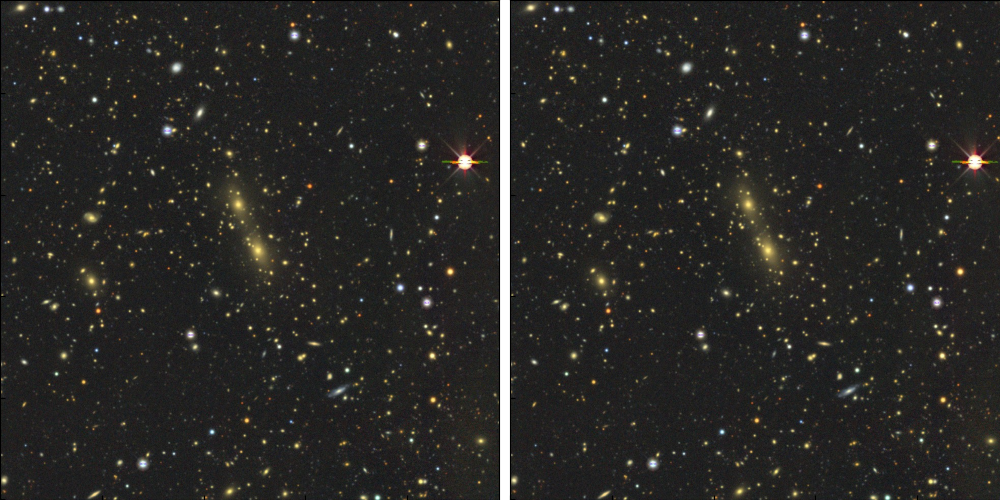

In [7]:
cur_pth = "raw_images/{n}/desi-ls/{n}_sidelength2000.0kpc_pixscale0.524arcsecperpix.jpeg".format(n=cur_row['name'])

im_data = {'desi-ls': plt.imread(cur_pth),
           'bodge': plt.imread(cur_pth)}
InteractiveView(im_data, 'desi-ls', figsize=(10, 5))

In [8]:
stop

NameError: name 'stop' is not defined

In [ ]:
for row_ind, row in samp.iterrows():
    break
cur_pth = "raw_images/{n}/desi-ls/{n}_sidelength2000.0kpc_pixscale0.524arcsecperpix.jpeg".format(n=row['name'])
print(row['name'])
plt.figure(figsize=(6, 6))

plt.gca().set_aspect(1)

im_data = plt.imread(cur_pth)
plt.imshow(im_data, origin='lower', aspect='equal')
plt.tick_params(left=False, bottom=False)
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show(block=False)

In [ ]:
im_data.shape